## Multi-class single label classification

The natural extension of binary classification is a multi-class classification task.

We first approach multi-class single-label classification, which makes the assumption that each example is assigned
to one and only one label.
For illustration purposes, we use the Iris flower data set, which consists of a classification into three
mutually-exclusive classes. Let us assume these classes are $A$, $B$, and $C$.

While one could train three unary
predicates $A(x)$, $B(x)$ and $C(x)$, it turns out to be more effective if this problem is modelled by a single
binary predicate $P(x,l)$, where $l$ is a variable denoting a multi-class label, in this case classes $A$, $B$, or $C$.
This syntax allows one to write statements quantifying over the classes, e.g. $\forall x(\exists l(P(x, l)))$, which states
that each example should be assigned at least one class.

Note that since the classes are mutually-exclusive in this case, the output layer of the $MLP$ representing predicate $P(x,l)$
will be a softmax layer, instead of a sigmoid function, to learn the probability of $A$, $B$, and $C$.

For this specific task, LTN uses the following language and grounding:

**Domains:**
- $items$, denoting the examples from the Iris flower data set;
- $labels$, denoting the class labels.

**Variables:**
- $x_A, x_B, x_C$ for the positive examples of classes $A$, $B$, and $C$;
- $x$ for all examples;
- $D(x_A) = D(x_B) = D(x_C) = D(x) = items$.

**Constants:**
- $l_A, l_B, l_C$, the labels of classes $A$ (Iris setosa), $B$ (Iris virginica), $C$ (Iris versicolor), respectively;
- $D(l_A) = D(l_B) = D(l_C) = labels$.

**Predicates:**
- $P(x,l)$ denoting the fact that item $x$ is classified as $l$;
- $D_{in}(P) = items,labels$.

**Axioms:**

- $\forall x_A P(x_A, l_A)$: all the examples of class $A$ should have label $l_A$;
- $\forall x_B P(x_B, l_B)$: all the examples of class $B$ should have label $l_B$;
- $\forall x_C P(x_C, l_C)$: all the examples of class $C$ should have label $l_C$.

Notice that rules about exclusiveness such as $\forall x (P(x, l_A) \implies (\lnot P(x, l_B) \land \lnot P(x, l_C)))$ are not included since such constraints are already imposed by the
grounding of $P$ below, more specifically by the *softmax* function.


**Grounding:**
- $\mathcal{G}(items)=\mathbb{R}^{4}$, items are described by 4 features: the length and the width of the sepals and
petals, in centimeters;
- $\mathcal{G}(labels)=\mathbb{N}^{3}$, we use a one-hot encoding to represent classes;
- $\mathcal{G}(x_A) \in \mathbb{R}^{m_1 \times 4}$, that is, $\mathcal{G}(x_A)$ is a sequence of $m_1$ examples of class $A$;
- $\mathcal{G}(x_B) \in \mathbb{R}^{m_2 \times 4}$, that is, $\mathcal{G}(x_B)$ is a sequence of $m_2$ examples of class $B$;
- $\mathcal{G}(x_C) \in \mathbb{R}^{m_3 \times 4}$, that is, $\mathcal{G}(x_C)$ is a sequence of $m_3$ examples of class $C$;
- $\mathcal{G}(x) \in \mathbb{R}^{(m_1+m_2+m_3) \times 4}$, that is, $\mathcal{G}(x)$ is a sequence of all the examples;
- $\mathcal{G}(l_A) = [1, 0, 0]$, $\mathcal{G}(l_B) = [0, 1, 0]$, $\mathcal{G}(l_C) = [0, 0, 1]$;
- $\mathcal{G}(P \mid \theta): x,l \mapsto l^\top \cdot \operatorname{softmax}\left(\operatorname{MLP}_{\theta}(x)\right)$, where $MLP$
has three output neurons corresponding to as many classes, and $\cdot$ denotes the dot product as a way of selecting an
output for $\mathcal{G}(P \mid \theta)$. In fact, multiplying the $MLP$’s output by the one-hot vector $l^\top$ gives the probability
corresponding to the class denoted by $l$.


### Dataset

Now, let's import the dataset.

The Iris flower dataset has three classes with 50 examples each. Every example is represented by 4 features. The dataset
is already subdivided into train and test set.

In [23]:
import torch
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt

In [24]:
!pip install LTNtorch

In [25]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [26]:
# Path to the dataset
data_main_path  = '/content/drive/MyDrive/ColabNotebooks/Winter Semester 2023 24/NSI/Datasets-20231011/'

In [27]:
train_data = pd.read_csv(os.path.join(data_main_path, "iris_training.csv"))
test_data = pd.read_csv(os.path.join(data_main_path, "iris_test.csv"))

In [28]:
train_labels = train_data.pop("species")
test_labels = test_data.pop("species")
train_data = torch.tensor(train_data.to_numpy()).float()
test_data = torch.tensor(test_data.to_numpy()).float()
train_labels = torch.tensor(train_labels.to_numpy()).long()
test_labels = torch.tensor(test_labels.to_numpy()).long()

### LTN setting

In order to define our knowledge base (axioms), we need to define predicate $P$, constants $l_A$, $l_B$, $l_C$,
universal quantifier, and the `SatAgg` operator.

For the quantifier, we use the stable product configuration (seen in the tutorials).

For predicate $P$, we have two models. The first one implements an $MLP$ which outputs the logits for the three classes of
the Iris flower dataset, given an example $x$ in input. The second model takes as input a labelled example $(x,l)$, it computes the logits
using the first model and then returns the prediction (*softmax*) for class $l$.

We need two separated models because we need both logits and probabilities. Logits are used to compute the classification
accuracy, while probabilities are interpreted as truth values to compute the satisfaction level of the knowledge base.

The constants $l_A$, $l_B$, and $l_C$, represent the one-hot labels for the three classes, as we have already seen in the
definition of the grounding for this task.

`SatAgg` is defined using the `pMeanError` aggregator.

In [29]:
import ltn

# ltn = LTNObject
# we define the constants
l_A = ltn.Constant(torch.tensor([1, 0, 0]))
l_B = ltn.Constant(torch.tensor([0, 1, 0]))
l_C = ltn.Constant(torch.tensor([0, 0, 1]))

# we define predicate P
class MLP(torch.nn.Module):
    """
    This model returns the logits for the classes given an input example. It does not compute the softmax, so the output
    are not normalized.
    This is done to separate the accuracy computation from the satisfaction level computation. Go through the example
    to understand it.
    """
    def __init__(self, layer_sizes=(4, 16, 16, 8, 3)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, training=False):
        """
        Method which defines the forward phase of the neural network for our multi class classification task.
        In particular, it returns the logits for the classes given an input example.

        :param x: the features of the example
        :param training: whether the network is in training mode (dropout applied) or validation mode (dropout not applied)
        :return: logits for example x
        """
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
            if training:
                x = self.dropout(x)
        logits = self.linear_layers[-1](x)
        return logits


class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=False):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)
        return out

mlp = MLP()
P = ltn.Predicate(LogitsToPredicate(mlp))

# we define the connectives, quantifiers, and the SatAgg
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Utils

Now, we need to define some utility classes and functions.

We define a standard PyTorch data loader, which takes as input the dataset and returns a generator of batches of data.
In particular, we need a data loader instance for training data and one for testing data.

Then, we define functions to evaluate the model performances. The model is evaluated on the test set using the following metrics:
- the satisfaction level of the knowledge base: measure the ability of LTN to satisfy the knowledge;
- the classification accuracy: measure the quality of the predictions.

In [30]:
from sklearn.metrics import accuracy_score
import numpy as np

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]

            yield data, labels


# define metrics for evaluation of the model

# it computes the overall satisfaction level on the knowledge base using the given data loader (train or test)
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        x_A = ltn.Variable("x_A", data[labels == 0])
        x_B = ltn.Variable("x_B", data[labels == 1])
        x_C = ltn.Variable("x_C", data[labels == 2])
        mean_sat += SatAgg(
            Forall(x_A, P(x_A, l_A)),
            Forall(x_B, P(x_B, l_B)),
            Forall(x_C, P(x_C, l_C))
        )
    mean_sat /= len(loader)
    return mean_sat

# it computes the overall accuracy of the predictions of the trained model using the given data loader
# (train or test)
def compute_accuracy(loader):
    mean_accuracy = 0.0
    for data, labels in loader:
        predictions = mlp(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        mean_accuracy += accuracy_score(labels, predictions)

    return mean_accuracy / len(loader)

# create train and test loader
train_loader = DataLoader(train_data, train_labels, 64, shuffle=True)
test_loader = DataLoader(test_data, test_labels, 64, shuffle=False)

### Learning

Let us define $D$ the data set of all examples. The objective function with $\mathcal{K}=\{\forall x_A P(x_A, l_A),\forall x_B P(x_B, l_B),\forall x_C P(x_C, l_C)\}$
is given by $\operatorname{SatAgg}_{\phi \in \mathcal{K}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{D}}(\phi)$.

In practice, the optimizer uses the following loss function:

$\boldsymbol{L}=\left(1-\underset{\phi \in \mathcal{K}}{\operatorname{SatAgg}} \mathcal{G}_{\boldsymbol{\theta}, x \leftarrow \boldsymbol{B}}(\phi)\right)$

where $B$ is a mini batch sampled from $D$.

In the following, we learn our LTN in the multi-class single-label classification task using the satisfaction of the knowledge base as
an objective. In other words, we want to learn the parameters $\theta$ of binary predicate $P$ in such a way the three
axioms in the knowledge base are maximally satisfied. We train our model for 500 epochs and use the `Adam` optimizer.

The following figure shows the LTN computational graph for this specific task.

![Computational graph](/examples/images/multi-class-single-label-classification.png)

In [21]:
optimizer = torch.optim.Adam(P.parameters(), lr=0.001)
train_sats = []
train_accs = []
test_sats = []
test_accs = []

for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels == 0]) # class A examples
        x_B = ltn.Variable("x_B", data[labels == 1]) # class B examples
        x_C = ltn.Variable("x_C", data[labels == 2]) # class C examples
        sat_agg = SatAgg(
            Forall(x_A, P(x_A, l_A, training=True)),
            Forall(x_B, P(x_B, l_B, training=True)),
            Forall(x_C, P(x_C, l_C, training=True))
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_accs.append(compute_accuracy(train_loader))
    train_sats.append(compute_sat_level(train_loader).detach().numpy())

    test_accs.append(compute_accuracy(test_loader))
    test_sats.append(compute_sat_level(test_loader).detach().numpy())

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

 epoch 0 | loss 0.6668 | Train Sat 0.348 | Test Sat 0.346 | Train Acc 0.352 | Test Acc 0.267
 epoch 20 | loss 0.5966 | Train Sat 0.436 | Test Sat 0.437 | Train Acc 0.701 | Test Acc 0.533
 epoch 40 | loss 0.4728 | Train Sat 0.575 | Test Sat 0.576 | Train Acc 0.706 | Test Acc 0.533
 epoch 60 | loss 0.4027 | Train Sat 0.639 | Test Sat 0.640 | Train Acc 0.939 | Test Acc 0.967
 epoch 80 | loss 0.3529 | Train Sat 0.695 | Test Sat 0.694 | Train Acc 0.949 | Test Acc 0.967
 epoch 100 | loss 0.3459 | Train Sat 0.749 | Test Sat 0.755 | Train Acc 0.967 | Test Acc 0.967
 epoch 120 | loss 0.2815 | Train Sat 0.790 | Test Sat 0.797 | Train Acc 0.984 | Test Acc 0.933
 epoch 140 | loss 0.2736 | Train Sat 0.818 | Test Sat 0.820 | Train Acc 0.983 | Test Acc 0.967
 epoch 160 | loss 0.2448 | Train Sat 0.822 | Test Sat 0.830 | Train Acc 0.967 | Test Acc 0.967
 epoch 180 | loss 0.2425 | Train Sat 0.840 | Test Sat 0.842 | Train Acc 0.967 | Test Acc 0.967
 epoch 200 | loss 0.2069 | Train Sat 0.844 | Test Sat 0.

Notice that variables $x_A$, $x_B$, and $x_C$ are grounded batch by batch with new data arriving from the data loader. This is exactly what
we mean with $\mathcal{G}_{x \leftarrow \boldsymbol{B}}(\phi(x))$, where $B$ is a mini-batch sampled by the data loader.

Notice also that `SatAgg` takes as input the three axioms and returns one truth value which can be interpreted as the satisfaction
level of the knowledge base.

Note that after 80 epochs the test accuracy is around 1. This shows the power of LTN in learning
the multi-class single-label classification task only using the satisfaction of a knowledge base as an objective.

## Modified LTN

In [41]:
x_A = ltn.Variable("x_A", data[labels == 0])
petal_length = x_A.value[:, -2]
petal_width = x_A.value[:, -1]

In [42]:
print(f"Petal length = {petal_length}")
print(f"Petal width = {petal_width}")

Petal length = tensor([1.5000, 1.3000, 1.2000, 1.5000, 1.2000, 1.6000, 1.3000, 1.4000, 1.5000,
        1.4000, 1.6000, 1.4000, 1.6000, 1.4000, 1.4000, 1.0000, 1.6000])
Petal width = tensor([0.2000, 0.2000, 0.2000, 0.4000, 0.2000, 0.2000, 0.2000, 0.2000, 0.4000,
        0.3000, 0.2000, 0.3000, 0.6000, 0.2000, 0.1000, 0.2000, 0.2000])


In [46]:
test = torch.where(x_A.value[:, -2] < 1.5, torch.tensor(1.0), torch.tensor(0.0))
print(test)

tensor([0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0.])


In [31]:
P2 = ltn.Predicate(func=lambda x: torch.where(x[:, -2] < 1.5, torch.tensor(1.0), torch.tensor(0.0)))
P3 = ltn.Predicate(func=lambda x: torch.where(x[:, -1] < 0.4, torch.tensor(1.0), torch.tensor(0.0)))

∀x : petal length(x) < 1.5 → setosa(x)  
∀x : petal width(x) < 0.4 → setosa(x)

In [32]:
optimizer2 = torch.optim.Adam(P.parameters(), lr=0.001)
train_sats2 = []
train_accs2 = []
test_sats2 = []
test_accs2 = []

for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer2.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels == 0]) # class A examples
        x_B = ltn.Variable("x_B", data[labels == 1]) # class B examples
        x_C = ltn.Variable("x_C", data[labels == 2]) # class C examples
        sat_agg = SatAgg(
            Forall(x_A, P(x_A, l_A, training=True)),
            Forall(x_B, P(x_B, l_B, training=True)),
            Forall(x_C, P(x_C, l_C, training=True)),
            Forall(x_A, P2(x_A)),
            Forall(x_A, P3(x_A))
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_accs2.append(compute_accuracy(train_loader))
    train_sats2.append(compute_sat_level(train_loader).detach().numpy())

    test_accs2.append(compute_accuracy(test_loader))
    test_sats2.append(compute_sat_level(test_loader).detach().numpy())

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

 epoch 0 | loss 0.6503 | Train Sat 0.323 | Test Sat 0.323 | Train Acc 0.301 | Test Acc 0.467
 epoch 20 | loss 0.6319 | Train Sat 0.356 | Test Sat 0.355 | Train Acc 0.715 | Test Acc 0.700
 epoch 40 | loss 0.5876 | Train Sat 0.460 | Test Sat 0.460 | Train Acc 0.842 | Test Acc 0.833
 epoch 60 | loss 0.5088 | Train Sat 0.587 | Test Sat 0.587 | Train Acc 0.876 | Test Acc 0.900
 epoch 80 | loss 0.4824 | Train Sat 0.641 | Test Sat 0.643 | Train Acc 0.959 | Test Acc 0.967
 epoch 100 | loss 0.4549 | Train Sat 0.709 | Test Sat 0.717 | Train Acc 0.975 | Test Acc 0.967
 epoch 120 | loss 0.4460 | Train Sat 0.771 | Test Sat 0.781 | Train Acc 0.984 | Test Acc 0.967
 epoch 140 | loss 0.4339 | Train Sat 0.804 | Test Sat 0.815 | Train Acc 0.974 | Test Acc 0.967
 epoch 160 | loss 0.4204 | Train Sat 0.834 | Test Sat 0.839 | Train Acc 0.983 | Test Acc 0.967
 epoch 180 | loss 0.4036 | Train Sat 0.847 | Test Sat 0.850 | Train Acc 0.983 | Test Acc 0.967
 epoch 200 | loss 0.4130 | Train Sat 0.862 | Test Sat 0.

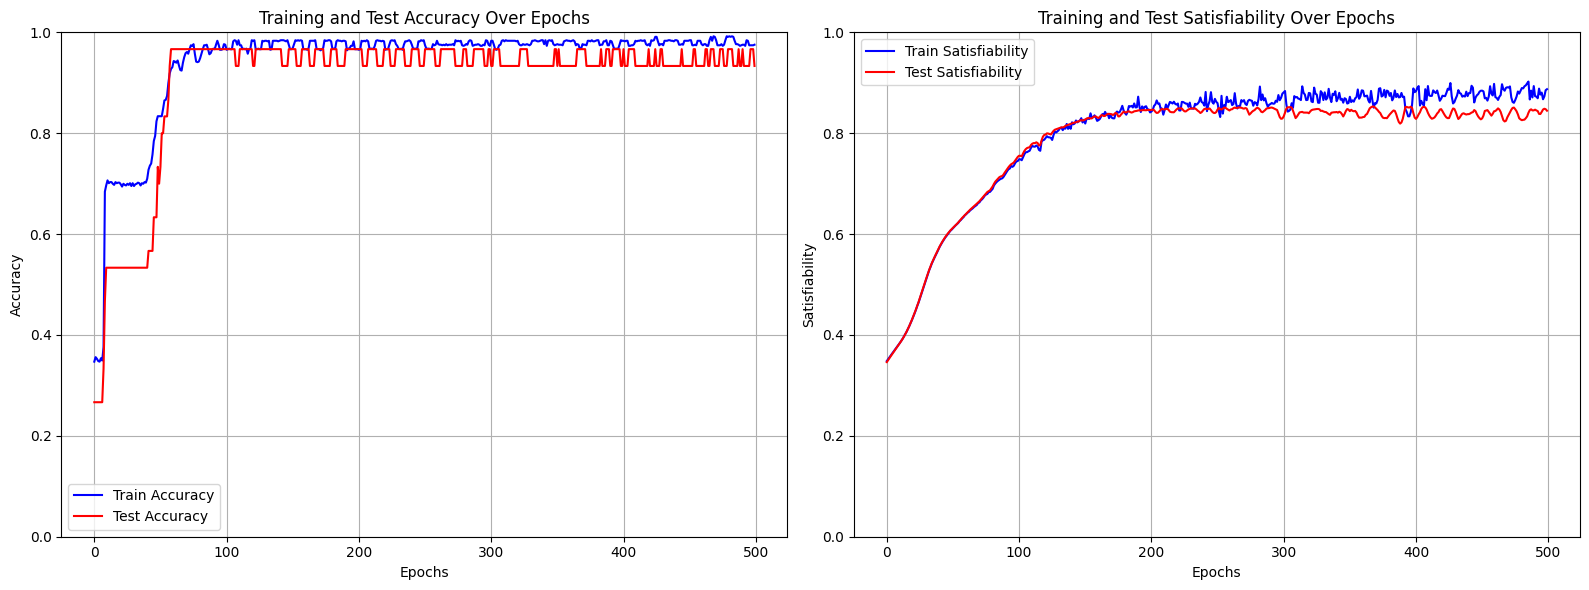

In [22]:
# Original
epochs = np.arange(0, 500, 1)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(epochs, train_accs, label='Train Accuracy', color='blue')
axs[0].plot(epochs, test_accs, label='Test Accuracy', color='red')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_title('Training and Test Accuracy Over Epochs')
axs[0].grid()
axs[0].set_ylim(0, 1)

axs[1].plot(epochs, train_sats, label='Train Satisfiability', color='blue')
axs[1].plot(epochs, test_sats, label='Test Satisfiability', color='red')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Satisfiability')
axs[1].legend()
axs[1].set_title('Training and Test Satisfiability Over Epochs')
axs[1].grid()
axs[1].set_ylim(0, 1)

plt.tight_layout()

plt.show()

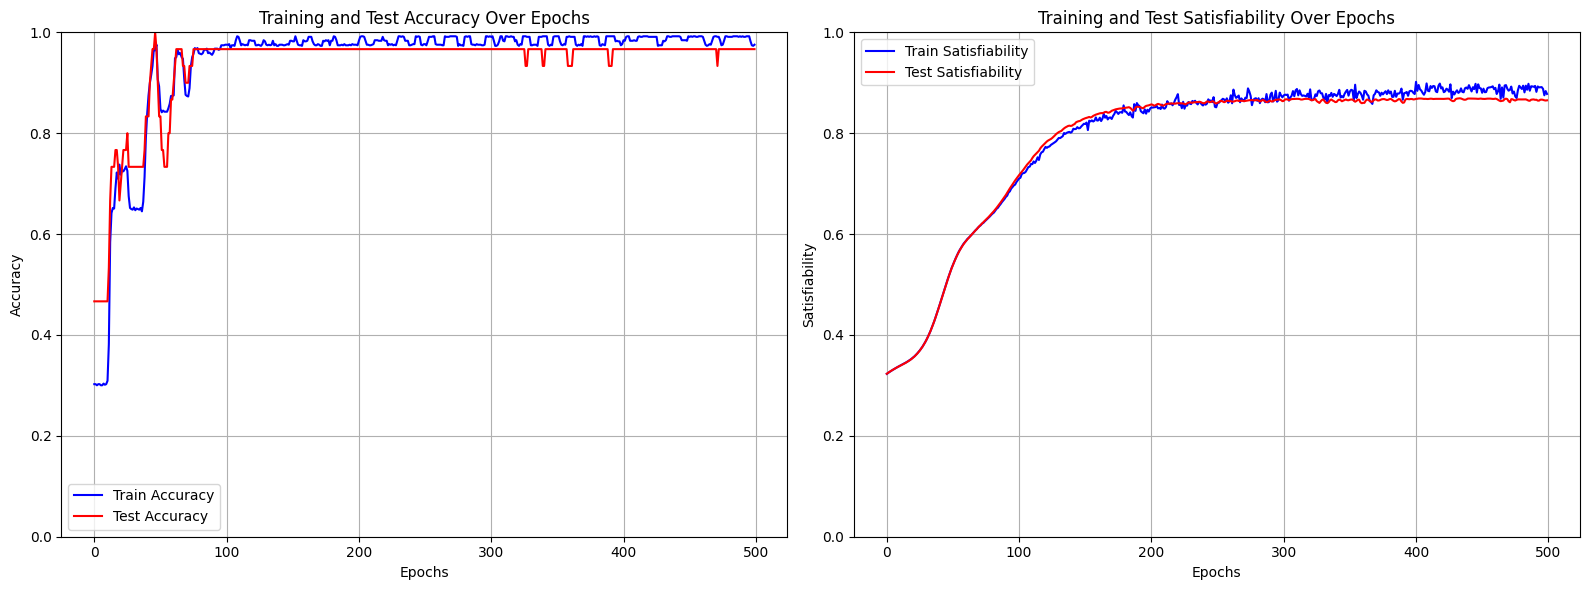

In [33]:
epochs = np.arange(0, 500, 1)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(epochs, train_accs2, label='Train Accuracy', color='blue')
axs[0].plot(epochs, test_accs2, label='Test Accuracy', color='red')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_title('Training and Test Accuracy Over Epochs')
axs[0].grid()
axs[0].set_ylim(0, 1)

axs[1].plot(epochs, train_sats2, label='Train Satisfiability', color='blue')
axs[1].plot(epochs, test_sats2, label='Test Satisfiability', color='red')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Satisfiability')
axs[1].legend()
axs[1].set_title('Training and Test Satisfiability Over Epochs')
axs[1].grid()
axs[1].set_ylim(0, 1)

plt.tight_layout()

plt.show()